<a href="https://colab.research.google.com/github/juliorodrigues07/manuscript_digit_recognition/blob/tuning/notebooks/digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLP and CNN for Manuscript Digits Recognition**

#[Table of Contents](#scrollTo=ZWjwmu48STPc)

>[MLP and CNN for Manuscript Digits Recognition](#scrollTo=ZWjwmu48STPc)

>[Imports and Export Directories](#scrollTo=93DT3HrxkSUL)

>[1. Initial Configurations](#scrollTo=uTG8EXyaM8kx)

>[2. Preprocessing](#scrollTo=RYNQUiCBjlfs)

>[3. Data Visualization](#scrollTo=mfJY4pR2hBwQ)

>[4. Neural Networks](#scrollTo=fQXlJ_IevXRx)

>>[4.1. MLP](#scrollTo=OErx9rlhU9QV)

>>[4.2. CNN](#scrollTo=nz_9iWQWW1DJ)

>>>[4.2.1. Holdout Learning](#scrollTo=Vkw15fhOgcD9)

>>>[4.2.2. Cross Validation](#scrollTo=SSs4M0--g9HE)

>[5. Predicting Instances](#scrollTo=QGQ2gyMkDIzq)

>>[5.1. Confusion Matrix](#scrollTo=5woCv7GyVv7A)

>>[5.2. Classifying Own Images](#scrollTo=s8TDQ7Oo-90V)

>[6. Saving Models](#scrollTo=XZfAkrTXbG7j)



# **Imports and Export Directories**

In [1]:
from os.path import isdir
from os      import getcwd
from os      import mkdir


if not isdir(f'{getcwd()}/../models'):
    mkdir(f'{getcwd()}/../models')
if not isdir(f'{getcwd()}/../plots'):
    mkdir(f'{getcwd()}/../plots')
if not isdir(f'{getcwd()}/../datasets'):
    mkdir(f'{getcwd()}/../datasets')
if not isdir(f'{getcwd()}/../datasets/digits'):
    mkdir(f'{getcwd()}/../datasets/digits')

# **1. Defining Initial Configurations and HyperParameters**

- Due to not offering support to the F1 metric (Macro F1 - Harmonic mean between precision and recall), we'll develop a custom implementation of it to evaluate the models' performances;
- Macro F1 doesn't consider class imbalance in calculation (unweighted), which tends to present lower values compared to Micro F1 with imbalanced datasets;
- In general, using the Macro F1 is better for evaluating a model, since a low accuracy with labels that correspond to minority classes will have the same impact as the majority ones on the final result;
- For instance, considering a binary classification problem (yes or no) with 80% of instances from the class _yes_ and 20% from the class _no_, a model that has a high accuracy predicting instances from _yes_ class and, in the other hand, extremely low results with _no_ class, tends to mask the results with Micro F1 (global accuracy with true/false positives and true/false negatives);
- The Macro F1 calculates accuracy scores for each classes before outputing the global result, making it more reliable to evaluate a model's performance visualing its scores for each class and the final unweighted mean.

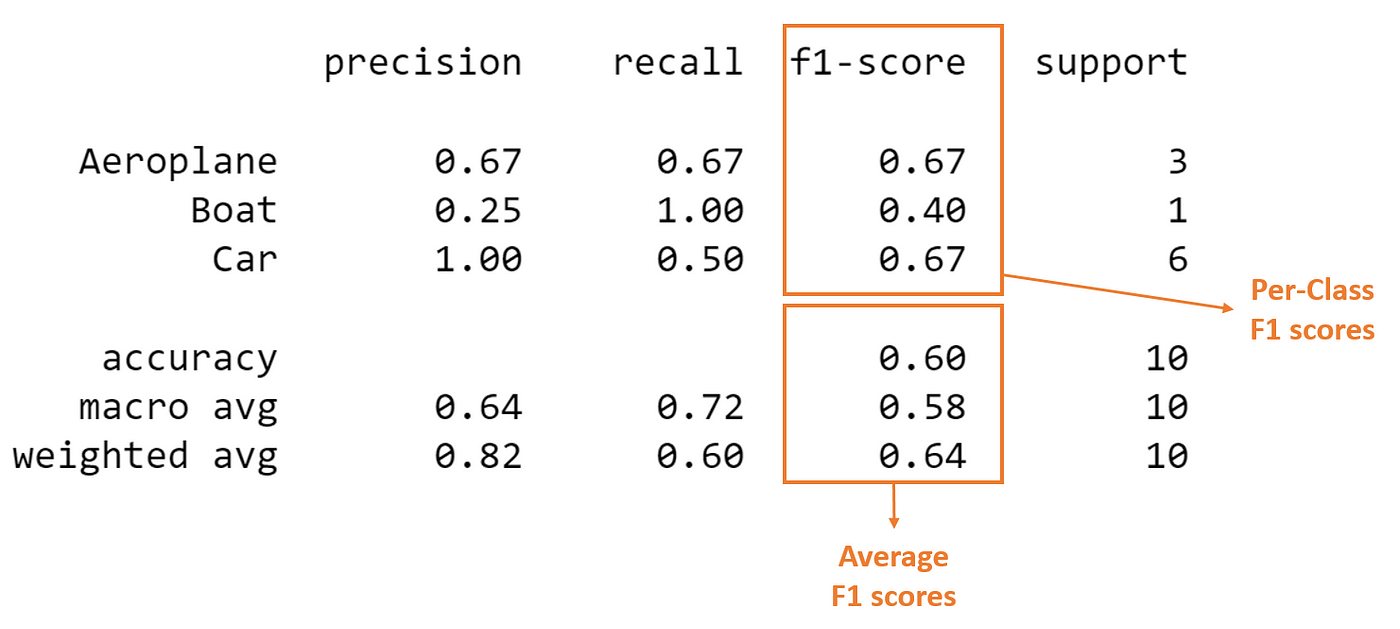

In [2]:
from keras import backend


def f1_score(ground_truth, prediction):

    def recall(ground_truth, prediction):
        '''Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        '''
        true_positives = backend.sum(backend.round(backend.clip(ground_truth * prediction, 0, 1)))
        possible_positives = backend.sum(backend.round(backend.clip(ground_truth, 0, 1)))
        recall = true_positives / (possible_positives + backend.epsilon())
        return recall

    def precision(ground_truth, prediction):
        '''Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        '''
        true_positives = backend.sum(backend.round(backend.clip(ground_truth * prediction, 0, 1)))
        predicted_positives = backend.sum(backend.round(backend.clip(prediction, 0, 1)))
        precision = true_positives / (predicted_positives + backend.epsilon())
        return precision

    precision = precision(ground_truth, prediction)
    recall = recall(ground_truth, prediction)

    return 2 * ((precision * recall) / (precision + recall + backend.epsilon()))

In [3]:
# Optimizer ('SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl')
opt = 'Adam'

# Loss (Multilabel classification)
lss = 'categorical_crossentropy'

# Activation functions ('relu', 'sigmoid', 'softplus', 'softsign', 'softmax', 'tanh', 'selu', 'elu', 'exponential')
actv_funct = 'relu'
exit_actv_funct = 'softmax'

# Batch size and number of epochs for training
b_size = 60
n_epochs = 4

# **2. Preprocessing**

- Since images are fundamentally matrices, we need to apply some transformation with that data to fit it to the NN input and possibly speed up its convergence;
- The whole dataset consists just of images, all which resolution is 28x28;
- We'll reshape this matrices to assume an array format (flattenning) of length 784 (28 * 28 = 784);
- Then, we'll compress the pixel values (0 to 255) into a new range from 0 to 1, which possibly will make the NNs converge faster.

In [7]:
from keras.utils    import to_categorical
from keras.datasets import mnist
import numpy as np


# Number of target labels (Digits from 0 to 9)
n_classes = 10

# Holdout split of the dataset (train and test)
(raw_training_attributes, raw_training_classes), (raw_test_attributes, raw_test_classes) = mnist.load_data()

# Discretizes the target labels (One-hot encoding)
training_classes = to_categorical(raw_training_classes, n_classes)
test_classes = to_categorical(raw_test_classes, n_classes)

# Converts an image (matrix) with 28 x 28 resolution to an array of size 784
reshaped_training = raw_training_attributes.reshape(60000, 784)
reshaped_test = raw_test_attributes.reshape(10000, 784)

# Normalizes the pixel values (0 to 255) between 0 and 1 (features)
training_attributes = reshaped_training.astype('float32') / 255
test_attributes = reshaped_test.astype('float32') / 255

11490434/11490434 [==============================] - 2s 0us/step


# **3. Data Visualization**

- Plotting a grid of sample images from the dataset.

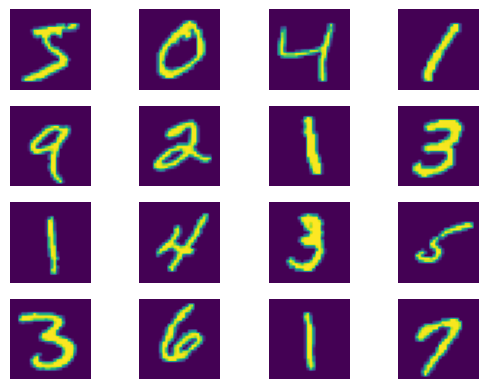

In [13]:
import matplotlib.pyplot as plt
import math


size = 16
sqrt_size = int(math.sqrt(size))

plt.figure()

for i in range(size):
  plt.subplot(sqrt_size, sqrt_size, i + 1)
  plt.imshow(raw_training_attributes[i])
  plt.axis('off')

plt.show()

# **4. Neural Networks**

Beyond this point, we'll draw our attention to experimenting with neural networks (MLP and CNN) and building an adequate model capable of recognizing manuscript digits.


## **4.1. MLP - Multi-Layer Perceptron**

- Simple _holdout_ learning, with 60k instances for training and 10k for validation (~85% | 15%);
- Completely connected neural network with two hidden layers.


In [ ]:
from keras.layers import Dense
from keras        import Sequential


# Defining the structure of the NN (number of layers, neurons, activation...)
dnn_model = Sequential([
    Dense(784, activation=actv_funct, input_dim=training_attributes.shape[1]),
    Dense(260, activation=actv_funct),
    Dense(130, activation=actv_funct),
    Dense(n_classes, activation=exit_actv_funct)
])

# NN summary and its training
dnn_model.summary()
dnn_model.compile(loss=lss, optimizer=opt, metrics=[f1_score])
dnn_model.fit(training_attributes, training_classes, batch_size=b_size, epochs=n_epochs, verbose=1)

# Model's performance
dnn_results = dnn_model.evaluate(test_attributes, test_classes, verbose=0)
print(f'\nLoss:      {str(round(dnn_results[0] * 100, 2))}%')
print(f'F1 Score: {str(round(dnn_results[1] * 100, 2))}%')

dnn_model.save(f'{getcwd()}/../models/DNN_tmp.keras')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 784)               615440    
                                                                 
 dense_1 (Dense)             (None, 260)               204100    
                                                                 
 dense_2 (Dense)             (None, 130)               33930     
                                                                 
 dense_3 (Dense)             (None, 10)                1310      
                                                                 
Total params: 854780 (3.26 MB)
Trainable params: 854780 (3.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/4
1000/1000 [==============================] - 8s 3ms/step - loss: 0.1969 - f1_score: 0.9369
Epoch 2/4
1000/1000 [==============================

## **4.2. CNN - Convolutional Neural Network**

- Main application with images, ideal for computer vision tasks;
- New arquitecture elements like filtering and downsampling layers;
- Often provides better results compared to a simple MLP, or even more sophisticated NNs.

![CNN](https://i.ibb.co/WktNrSG/gec2.jpg)

- About the CNN architecture:
    - **Convolutional Layer** (Conv2D): Extracts N filter maps (based on the number of filters) using a weighted feature detector (i.e., 2D matrix or kernel) that sweeps across the entire image performing element wise multiplications. In this case, it's used _same_ padding, which indicates that the output layer has the same size as the input layer (information preservation);

    ![Conv](https://i.ibb.co/L02sZ85/gec.jpg)

    - **Pooling Layer** (MaxPool2D): Acts as a downsampler performing dimensionaluty reduction. A, unweighted filter sweeps across the image, in this case selecting pixels which have the maximum value in the neighborhood (i.e., kernel size);

    ![MaxPool](https://i.ibb.co/NnDxRKp/maxpool.jpg)

    - **Dropout**: A regularization method where a proportion of nodes in the layer are randomly ignored for each training sample. This may force the network to learn features in a distributed way, also improving generalization and reducing overfitting.

    ![Dropout](https://i.ibb.co/Z63Kftm/dropout.jpg)

    - The "standard" layers are, in graph terminology, fully conected, which means that each neuron is connected with every other neurons from the previous and successor layers. However, since we're dealing with a feedforward NN, it can be visualized as a directed acyclic graph (i.e., information only travels forward through the nodes and cannot "go back" to previous ones);

    - The activation function used through all the CNN layers (except for the last one) is ReLU (Rectified Linear Unit), which is used to add non-linearity to the network, since imagen are non-linear. Also, the use of convolutional and pooling layers often times reduces the computational cost on fitting the model (dimensionality reduction), compared to simples MLPs.

In [18]:
from keras.layers import MaxPool2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D

def create_model():

    model = Sequential()

    # Initial pair of convolutional layers
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation=actv_funct, input_shape=(28, 28, 1)))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation=actv_funct))

    # Downsampling layer picking maximal values by filtering pixel neighborhoods
    model.add(MaxPool2D(pool_size=(2, 2)))

    # Dropout step (Randomly discards neurons at each N training steps to reduce overfitting)
    model.add(Dropout(0.25))

    # Final pair of convolutional layers, again along with pooling layer and dropout step
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=actv_funct))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=actv_funct))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Dropout(0.25))

    # Flattening layer that maps the features in an 1D array (e.g., 4x4 matrix into 16 length array)
    model.add(Flatten())

    # Hidden layer completely connected with output layer (dropout applied between them)
    model.add(Dense(256, activation=actv_funct))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation=exit_actv_funct))

    return model

### **4.2.1. Holdout Learning**


In [ ]:
# Data resizing, adapting to CNN utilization
cnn_training_attributes = training_attributes.reshape(60000, 28, 28, 1)
cnn_test_attributes = test_attributes.reshape(10000, 28, 28, 1)

# CNN training
cnn_model = create_model()
cnn_model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])
# cnn_model.compile(optimizer=opt, loss=lss, metrics=[f1_score])
cnn_model.fit(cnn_training_attributes, training_classes, epochs=n_epochs, batch_size=b_size)

# Model's performance
cnn_results = cnn_model.evaluate(cnn_test_attributes, test_classes, verbose=0)
print(f'\nLoss:      {str(round(cnn_results[0] * 100, 2))}%')
print(f'F1 Score: {str(round(cnn_results[1] * 100, 2))}%')

cnn_model.save(f'{getcwd()}/../models/CNN_tmp.keras')

### **4.2.2. Cross Validation**

- Holdout learning can be deceiving when it comes to evaluating models, since we're constantly testing with a fixed portion of the dataset;
- Therefore, we'll make use of a stratified k-fold cross validation to obtain more reliable results;
- Stratified K-Fold CV maintains the target classes proportion between each fold. For instance, a binary problem whose dataset that contains 80% of instance from class A and 20% of class B, will have each fold with the same proportion between classes to even the training steps and avoid underfitting (e.g., training almost only with class A instances and testing with class B instances);
- We will split the dataset in fold (5 in this case), selecting one of them at a time to be our test set and the remaining one used in training (i.e., multiple holdouts with different splits);
- The final result will be the average of the f1 scores obtained from each holdout learning step with the k different splits.

In [23]:
from sklearn.model_selection import RepeatedStratifiedKFold


# Whole dataset for fitting and saving final models
features = np.append(raw_training_attributes, raw_test_attributes)
classes = np.append(raw_training_classes, raw_test_classes)

# Preprocessing
reshaped_features = features.reshape(70000, 784)
training_features = reshaped_features.astype('float32') / 255

cnn_final_features = training_features.reshape(70000, 28, 28, 1)
final_classes = to_categorical(classes, n_classes)

# 5-fold cross validation repeated 10 times for model evaluation
f1_per_fold, loss_per_fold = list(), list()
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# KFold.split method doesn't support target which was one-hot enconded
for train, test in kfold.split(cnn_final_features, classes):

    cv_model = create_model()
    cv_model.compile(optimizer=opt, loss=lss, metrics=[f1_score])
    history = cv_model.fit(cnn_final_features[train], final_classes[train],
                           batch_size=70, epochs=n_epochs, verbose=0)

    # Gathering the results
    scores = cv_model.evaluate(cnn_final_features[test], final_classes[test], verbose=0)
    f1_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('\nResults: Average F1 Score and Loss\n')
print(f'F1 Score: Mean - {round(np.mean(f1_per_fold), 2)}% | Std - {round(np.std(f1_per_fold), 2)}')
print(f'Loss:     Mean -  {round(np.mean(loss_per_fold) * 100, 2)}%')


Results: Average F1 Score and Loss

F1 Score: Mean - 99.12% | Std - 0.11
Loss:     Mean -  3.0%


# **5. Predicting Instances and Analyzing Results**

In [15]:
def visualize_predictions(attributes, n, c_map, model):

    final = np.argmax(model.predict(attributes[0 : n], verbose=0), axis=-1)

    fig, ax = plt.subplots(nrows=math.ceil(n / 5), ncols=5)
    ax = ax.flatten()

    print(f'Predictions for the first {n} images:')

    for i in range(n):
        print(final[i], end=' | ')

        if int((i + 1) % 5) == 0:
            print('\t')

        img = attributes[i].reshape((28, 28))
        plt.axis("off")

        ax[i].imshow(img, cmap=c_map, interpolation='nearest')
        ax[i].axis("off")

    print(f'\nFirst {n} from the test set:')

In [26]:
from keras.models import load_model


# file_name = f'{getcwd()}/../models/CNN_{str(n_epochs)}_70_{str(actv_funct)}_{str(exit_actv_funct)}_{str(opt)}_{str(lss)}.keras'
file_name = f'{getcwd()}/../models/CNN_tmp.keras'

loaded_model = load_model(file_name)
loaded_model.summary()

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_244 (Conv2D)         (None, 28, 28, 32)        832       
                                                                 
 conv2d_245 (Conv2D)         (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_122 (MaxPool  (None, 14, 14, 32)        0         
 ing2D)                                                          
                                                                 
 dropout_182 (Dropout)       (None, 14, 14, 32)        0         
                                                                 
 conv2d_246 (Conv2D)         (None, 14, 14, 64)        18496     
                                                                 
 conv2d_247 (Conv2D)         (None, 14, 14, 64)        36928     
                                                     

1/1 [==============================] - 0s 60ms/step
Predictions for the first 25 images:
7 | 2 | 1 | 0 | 4 | 	
1 | 4 | 9 | 5 | 9 | 	
0 | 6 | 9 | 0 | 1 | 	
5 | 9 | 7 | 3 | 4 | 	
9 | 6 | 6 | 5 | 4 | 	

First 25 from the test set:


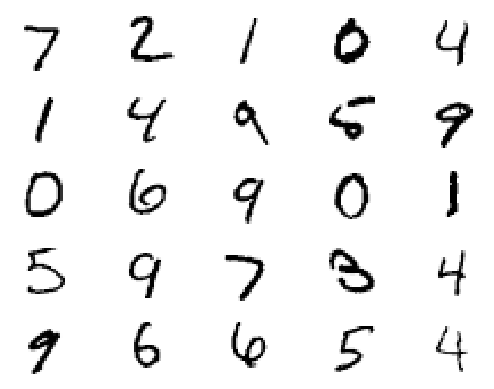

In [ ]:
visualize_predictions(cnn_test_attributes, 25, 'Greys', loaded_model)

## **5.1. Confusion Matrix**


313/313 [==============================] - 1s 2ms/step


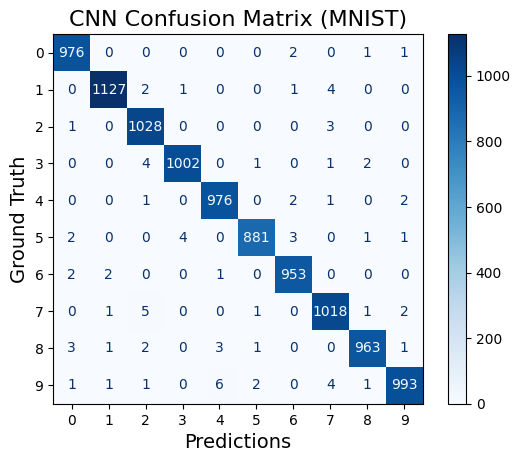

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


# Executes predictions
final = np.argmax(loaded_model.predict(cnn_test_attributes), axis=-1)

# Formats the data from ground truth to compare with predictions
cnn_test_classes = list()
for i in range(len(test_classes)):
  cnn_test_classes.append(np.argmax(test_classes[i]))

# Labels' names (Digits from 0 to 9)
class_names = [str(i) for i in range(n_classes)]

# Confusion matrix graph plot
ConfusionMatrixDisplay.from_predictions(cnn_test_classes, final, display_labels=class_names, cmap='Blues')
plt.title('CNN Confusion Matrix (MNIST)', fontsize=16)
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Ground Truth', fontsize=14)

plt.savefig(f'{getcwd()}/../plots/confusion_matrix_cnn.svg', format='svg')
plt.show()

## **5.2. Classifying Own Images**

Predictions for the first 13 images:
2 | 4 | 2 | 2 | 2 | 	
9 | 5 | 9 | 2 | 2 | 	
5 | 9 | 7 | 
First 13 from the test set:


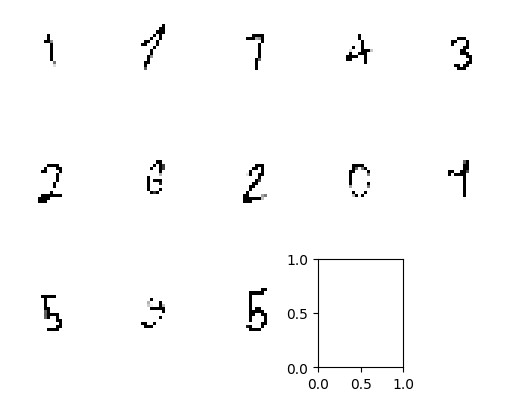

In [27]:
# Earlier versions of gdown may have bugs on downloading directories
!pip install --upgrade -q gdown

from os import listdir
import cv2 as cv
import gdown


img_set = list()

digits_dir = f'{getcwd()}/../datasets/digits'
dir_id = '1YehrBNViI4tsiWYA3gcarn9NQ7Sv6LwG'
gdown.download_folder(f'https://drive.google.com/drive/folders/{dir_id}', output=digits_dir, quiet=True)

# Directory containing the list with image files names
images = listdir(digits_dir)

for img in images:

  # Non-image hidden file
  if img != '.ipynb_checkpoints':

    img = cv.imread(f'{digits_dir}/{img}')
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Blurs and binarizes the image to possibly remove noisy data (e.g., black dots)
    blurred = cv.GaussianBlur(gray, (37, 37), 0)
    _, binarized = cv.threshold(blurred, 140, 255, cv.THRESH_BINARY)

    # Resizes the image resolution to 28 x 28 (CNN input size fixed)
    resized = cv.resize(binarized, (28, 28), interpolation=cv.INTER_CUBIC)
    img_set.append(resized)

# Raw data from the real images
raw_instances = np.array(img_set)

# Preprocessing
reshaped = raw_instances.reshape(13, 784)
real_test = reshaped.astype('float32') / 255
cnn_test = real_test.reshape(13, 28, 28, 1)

# Predictions
visualize_predictions(cnn_test, 13, 'gray', loaded_model)

# **6. Saving Models**

In [25]:
# Can't save model with custom f1 score
dnn_model.compile(loss=lss, optimizer=opt, metrics=['accuracy'])
dnn_model.fit(training_features, final_classes, batch_size=70, epochs=n_epochs)
dnn_model.save(f'{getcwd()}/../models/DNN_{str(n_epochs)}_{str(70)}_{str(actv_funct)}_{str(exit_actv_funct)}_{str(opt)}_{str(lss)}.keras')

cnn_model = create_model()
cnn_model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])
cnn_model.fit(cnn_final_features, final_classes, epochs=n_epochs, batch_size=70)
cnn_model.save(f'{getcwd()}/../models/CNN_{str(n_epochs)}_{str(70)}_{str(actv_funct)}_{str(exit_actv_funct)}_{str(opt)}_{str(lss)}.keras')

Epoch 1/4
1000/1000 [==============================] - 9s 5ms/step - loss: 0.1816 - accuracy: 0.9445
Epoch 2/4
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0749 - accuracy: 0.9770
Epoch 3/4
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0526 - accuracy: 0.9831
Epoch 4/4
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0380 - accuracy: 0.9875
Epoch 1/4
1000/1000 [==============================] - 9s 7ms/step - loss: 0.1719 - accuracy: 0.9458
Epoch 2/4
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0596 - accuracy: 0.9815
Epoch 3/4
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0470 - accuracy: 0.9855
Epoch 4/4
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0386 - accuracy: 0.9884
